<a href="https://colab.research.google.com/github/Hackman-git/Mechanisms_of_action/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What has been tried so far:

*   Scaling numeric features (improved loss)
*   Label smoothing (improved loss)
*   Clipping (improved loss)
*   Learning rate selection (improved loss)
*   Batch size selection (128 seems best)
*   Model architectures (3 wide layers seem best so far)
*   Transfer learning with non_scored targets (didn't improve loss)
*   Upsampling with multi-label SMOTE (didn't improve loss)
*   Feature selection (variance thresholding)
*   Dimensionality reduction (PCA)

To explore:
*   Dealing with imbalance (MLSMOTE didn't help)
*   Deeper nets
*   Ensembles






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import tensorflow_addons as tfa
from tensorflow import keras
from keras import backend
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [2]:
train_x = pd.read_csv('/content/drive/My Drive/MOA/Data/train_features.csv')
train_y = pd.read_csv("/content/drive/My Drive/MOA/Data/train_targets_scored.csv")
train_y_ns = pd.read_csv("/content/drive/My Drive/MOA/Data/train_targets_nonscored.csv")
test = pd.read_csv("/content/drive/My Drive/MOA/Data/test_features.csv")
submit = pd.read_csv("/content/drive/My Drive/MOA/Data/sample_submission.csv")

In [3]:
train_x.shape, train_y.shape, train_y_ns.shape

((23814, 876), (23814, 207), (23814, 403))

Preprocessing steps

In [4]:

# map cp_type to binary
train_x.cp_type = train_x.cp_type.map({'trt_cp': 1, 'ctl_vehicle': 0})
test.cp_type = test.cp_type.map({'trt_cp': 1, 'ctl_vehicle': 0})

# we don't need ctl_vehicle
train_y = train_y.loc[train_x['cp_type']==1].reset_index(drop=True)
train_y_ns = train_y_ns.loc[train_x['cp_type']==1].reset_index(drop=True)
train_x = train_x.loc[train_x['cp_type']==1].reset_index(drop=True)

cols = train_x.columns
cell_cols = [col for col in cols if col.startswith("c-")]
gene_cols = [col for col in cols if col.startswith('g-')]

print('num of cell viability features: ', len(cell_cols))
print('num of gene features: ', len(gene_cols))

num of cell viability features:  100
num of gene features:  772


In [5]:
# numeric cols
num = ['cp_time'] + cell_cols + gene_cols
rem = ['cp_type']
train_x_num = train_x[num]

# categorical cols
cat = ['cp_dose']
train_x_cat = train_x[cat]

# one-hot encoding
oneHotEnc = OneHotEncoder(handle_unknown='ignore', sparse=False)
fit = oneHotEnc.fit_transform(train_x_cat)
train_x_oneH = pd.DataFrame(fit, columns=['dose_1', 'dose_2'])
fit_ = oneHotEnc.transform(test[cat])
test_oneH = pd.DataFrame(fit_, columns=['dose_1', 'dose_2'])

# scaling numeric features
scaler = StandardScaler()
train_x_num_tr = scaler.fit_transform(train_x_num)
train_x_num_tr = pd.DataFrame(train_x_num_tr, columns=num)

test_num_tr = scaler.transform(test[num])
test_num_tr = pd.DataFrame(test_num_tr, columns=num)

# merging all transformed columns
train_x_trans = pd.concat([train_x[['cp_type']].reset_index(drop=True),
                        train_x_oneH.reset_index(drop=True)], axis=1)
train_x_trans = pd.concat([train_x_trans.reset_index(drop=True),
                        train_x_num_tr.reset_index(drop=True)], axis=1)
test_trans = pd.concat([test[['cp_type']].reset_index(drop=True),
                        test_oneH.reset_index(drop=True)], axis=1)
test_trans = pd.concat([test_trans.reset_index(drop=True),
                        test_num_tr.reset_index(drop=True)], axis=1)

# dropping sig_id (not a feature)
train_y.drop(columns=['sig_id'], inplace=True)
train_y_ns.drop(columns=['sig_id'], inplace=True)

In [6]:
train_x_trans.shape, train_y.shape

((21948, 876), (21948, 206))

In [7]:
train_x_trans.head(2)

,cp_type,dose_1,dose_2,cp_time,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1,1.0,0.0,-1.237682,0.185863,0.299556,0.584655,0.508021,0.452127,-0.093050,0.400912,0.491091,0.082576,0.496545,0.683094,0.575527,0.733252,0.606676,0.150916,0.420044,0.610762,0.121331,0.122997,0.626120,0.800853,0.433343,0.012916,0.075132,0.115101,0.519260,0.35307,0.700635,0.612104,0.599306,0.453757,0.151243,0.410313,0.428815,0.503454,0.133187,...,-1.080000,-0.406928,0.662550,-0.470207,0.154020,-0.188836,0.427979,0.061997,0.353517,-0.203396,1.168142,1.120206,-0.578124,-0.10838,1.228400,-0.980524,0.208762,0.023364,-0.445551,-0.130299,-0.543136,1.211372,-0.168809,-0.978152,-0.262421,-0.743560,-0.328860,0.204498,0.999794,0.410226,-0.664507,-0.264137,0.624743,-0.014495,0.894254,-0.441400,0.139851,1.410500,0.407781,-0.106759
1,1,1.0,0.0,1.236104,0.270276,0.378936,0.389892,0.740972,0.427375,0.547195,0.398615,1.138755,0.436894,0.695134,0.622257,0.349948,0.755417,0.375024,0.339412,0.591750,-0.032955,0.145779,0.464404,0.288794,0.723007,0.268803,0.521626,0.199981,0.255687,0.343897,0.56935,0.429033,0.698217,0.241424,0.553478,0.453691,0.304814,0.433748,0.636668,0.590326,...,2.595002,0.215975,-0.201148,0.371009,-0.332716,-0.118738,0.875297,-0.374516,-0.379582,-0.181888,-0.690119,0.066303,0.127644,0.18220,-1.439416,-0.000402,0.278691,0.145143,-0.591795,-0.123478,0.244504,-1.444981,-0.455061,0.330476,-0.758251,0.107354,-0.190331,0.053135,0.308824,0.802095,-0.690314,0.012612,-0.535728,0.179280,-0.391350,-0.054182,-0.341499,-0.181268,-0.055649,-0.279529


In [8]:
train_y.head(2)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature engineering

PCA

In [9]:
# PCA on Cell features (20 comps)

train_test_cell = pd.concat([pd.DataFrame(train_x_trans[cell_cols]), pd.DataFrame(test_trans[cell_cols])])
pca_df_cell = PCA(n_components=20, random_state=42).fit_transform(train_test_cell)
train_pca_cell = pca_df_cell[:train_x_trans.shape[0]]
test_pca_cell = pca_df_cell[-test_trans.shape[0]: ]

train_pca_cell = pd.DataFrame(train_pca_cell, columns=['pca_cell'+str(i) for i in range(train_pca_cell.shape[1])])
test_pca_cell = pd.DataFrame(test_pca_cell, columns=['pca_cell'+str(i) for i in range(test_pca_cell.shape[1])])

train_x_pca = pd.concat([train_x_trans, train_pca_cell], axis=1)
test_pca = pd.concat([test_trans, test_pca_cell], axis=1)

In [10]:
print(train_x_pca.shape, test_pca.shape)

(21948, 896) (3982, 896)


In [11]:
# PCA on Gene features (100 comps)

train_test_gene = pd.concat([pd.DataFrame(train_x_trans[gene_cols]), pd.DataFrame(test_trans[gene_cols])])
pca_df_gene = PCA(n_components=100, random_state=42).fit_transform(train_test_gene)
train_pca_gene = pca_df_gene[:train_x_trans.shape[0]]
test_pca_gene = pca_df_gene[-test_trans.shape[0]: ]

train_pca_gene = pd.DataFrame(train_pca_gene, columns=['pca_gene_'+str(i) for i in range(train_pca_gene.shape[1])])
test_pca_gene = pd.DataFrame(test_pca_gene, columns=['pca_gene_'+str(i) for i in range(test_pca_gene.shape[1])])

train_x_pca = pd.concat([train_x_pca, train_pca_gene], axis=1)
test_pca = pd.concat([test_pca, test_pca_gene], axis=1)

In [12]:
print(train_x_pca.shape, test_pca.shape)

(21948, 996) (3982, 996)


Variance Thresholding

In [13]:
var_thresh = VarianceThreshold(threshold=0.5)
train_test_vt = pd.concat([train_x_pca, test_pca])

In [14]:
var_thresh_df = var_thresh.fit_transform(train_test_vt)

train_x_vt = var_thresh_df[ : train_x_pca.shape[0]]
test_vt = var_thresh_df[-test_pca.shape[0] : ]

train_x_vt = pd.concat([train_x_pca, pd.DataFrame(train_x_vt, \
                        columns=['vt_'+str(i) for i in range(train_x_vt.shape[1])])], axis=1)
test_vt = pd.concat([test_pca, pd.DataFrame(test_vt, \
                        columns=[['vt_'+str(i) for i in range(test_vt.shape[1])]])], axis=1)


In [15]:
train_x_vt.shape, test_vt.shape

((21948, 1973), (3982, 1973))

Final variables

In [16]:
final_features = train_x_vt.columns
train_x_final = train_x_vt
train_y_final = train_y
test_final = test_vt

In [17]:
def model_init(out_layer_size=train_y.shape[1]):
    # initializing the model
    model = keras.models.Sequential([
        Dense(2048, activation='elu', input_shape=(train_x_final.shape[1],), kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1024, activation='elu',kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(512, activation='elu',kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(out_layer_size, activation='sigmoid')
    ])
    
    # compile model
    model.compile(loss=keras.losses.BinaryCrossentropy(label_smoothing=0.001), 
                  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  metrics=logloss)
    
    
    return (model)

In [18]:
# clipping thresholds
c_min = 0.001
c_max = 0.999

In [19]:
def training(train_x_trans, train_y, train_y_ns, k=5, batch_size=128, epochs=50, num_seeds=2, use_nonscored=False):
    '''
    This function trains the neural net on the non-scored targets (if use_nonscored=True) and uses
    transfer learning on the scored targets, otherwise it trains only the scored targets.
    '''
    num_labels = train_y.shape[1]
    num_train = train_x_trans.shape[0]
    num_features = train_x_trans.shape[1]
    num_test = test_final.shape[0]

    # initialize a number of seeds
    seeds = np.random.randint(0,100,size=num_seeds)
    # initialize predictions dataframe
    y_pred = np.zeros((num_test, num_labels))
    # initialize out of fold loss
    oof_loss = tf.constant(0.0)
    # store model history
    model_hist = []

    for seed in seeds:
        fold = 1
        # stratified split
        strat = KFold(k, shuffle=True, random_state=seed)
        for fold, (train, test) in enumerate(strat.split(train_x_trans, train_y)):
            # subset of data for training and cross-validation
            x_train = train_x_trans.values[train]
            x_test = train_x_trans.values[test]
            y_train = train_y.values[train]
            y_train_ns = train_y_ns.values[train]
            y_test = train_y.values[test]
            y_test_ns = train_y_ns.values[test]

            print('\nSeed '+str(seed)+', fold '+str(fold+1))
            
            # defining callbacks
            lr_scheduler = keras.callbacks.ReduceLROnPlateau(
                factor=0.2, patience=4, monitor='val_logloss',mode='min',min_lr=1E-5)
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_logloss', min_delta=1E-5, patience=6,
                mode='min',restore_best_weights=True)
            
            # save the best model with a checkpoint callback
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    '/content/drive/My Drive/MOA/Models/Model_Seed_'+str(seed)+'_fold_'+str(fold)+'.h5',
                    save_best_only=True)
            
            model2 = model_init()

            if use_nonscored:
                # train on non-scored targets the use transfer learning
                model = model_init(out_layer_size=402)
                checkpoint_ns = tf.keras.callbacks.ModelCheckpoint(
                    '/content/drive/My Drive/MOA/Models/Model_NS_Seed_'+str(seed)+'_fold_'+str(fold)+'.h5',
                    save_best_only=True)
                
                print('\n----------------Non-scored-------------------\n')

                mod_ns = model.fit(x_train, y_train_ns, validation_data=(x_test,y_test_ns),
                                callbacks=[lr_scheduler,early_stopping,checkpoint_ns],
                                batch_size = batch_size, epochs=epochs)
                model_hist.append(mod_ns)
                model.load_weights('/content/drive/My Drive/MOA/Models/Model_NS_Seed_'+str(seed)+'_fold_'+str(fold)+'.h5')

                for i in range(len(model2.layers)-1):
                    model2.layers[i].set_weights(model.layers[i].get_weights())


            print('\n----------------Scored-------------------\n')
            # train on scored targets
            mod = model2.fit(x_train, y_train, validation_data=(x_test,y_test),
                            callbacks=[lr_scheduler,early_stopping,checkpoint],
                            batch_size = batch_size, epochs=epochs)
            
            # plot learning curves
            pd.DataFrame(mod.history).plot(figsize=(10,5))
            
            model_hist.append(mod)
            # model.save('./Model_Seed_'+str(seed)+'_fold_'+str(fold)+'.h5')

            model2.load_weights('/content/drive/My Drive/MOA/Models/Model_Seed_'+str(seed)+'_fold_'+str(fold)+'.h5')
            # out of fold prediction for current fold
            oof_pred = model2.predict(x_test)
            # out of fold loss for current fold
            current_oof_loss = logloss(tf.constant(y_test,dtype=tf.float32),
                                tf.constant(oof_pred,dtype=tf.float32))
            tf.print(current_oof_loss)
            oof_loss += current_oof_loss

            # predict on test set with current model
            y_pred += model2.predict(test_final)

    # average results from all models
    oof_loss = oof_loss/(k*num_seeds)
    y_pred = y_pred / (k*num_seeds)

    tf.print('\noof loss after '+str(len(seeds))+' seeds of '+str(k)+'-fold CV is: ',oof_loss)

    test_pred = submit.copy()
    y_cols = submit.columns[1:]
    # clip the predictions to improve loss
    test_pred.iloc[:,1:] = np.clip(y_pred, c_min, c_max)
    # set control treatment prediction results to zero
    test_pred.loc[test_final['cp_type']==0, y_cols] = 0

    return(test_pred)


In [20]:
def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,c_min,c_max)
    return (-backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred)))



Seed 22, fold 1

----------------Scored-------------------

Epoch 1/50
147/147 [==============================] - 3s 21ms/step - loss: 0.6508 - logloss: 0.6486 - val_loss: 0.2863 - val_logloss: 0.2843
Epoch 2/50
147/147 [==============================] - 1s 10ms/step - loss: 0.1417 - logloss: 0.1400 - val_loss: 0.0486 - val_logloss: 0.0467
Epoch 3/50
147/147 [==============================] - 1s 9ms/step - loss: 0.0418 - logloss: 0.0395 - val_loss: 0.0296 - val_logloss: 0.0272
Epoch 4/50
147/147 [==============================] - 1s 9ms/step - loss: 0.0297 - logloss: 0.0271 - val_loss: 0.0255 - val_logloss: 0.0228
Epoch 5/50
147/147 [==============================] - 1s 9ms/step - loss: 0.0266 - logloss: 0.0237 - val_loss: 0.0239 - val_logloss: 0.0211
Epoch 6/50
147/147 [==============================] - 3s 17ms/step - loss: 0.0249 - logloss: 0.0219 - val_loss: 0.0228 - val_logloss: 0.0198
Epoch 7/50
147/147 [==============================] - 1s 9ms/step - loss: 0.0239 - logloss: 0.02

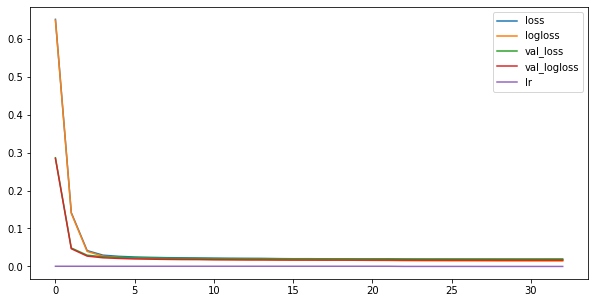

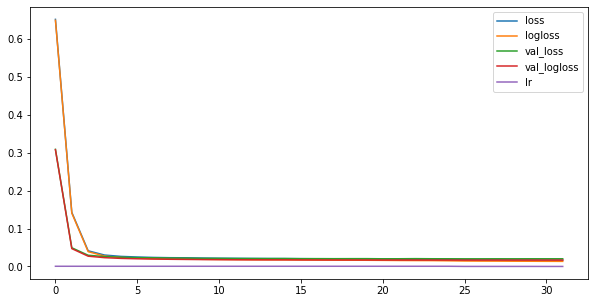

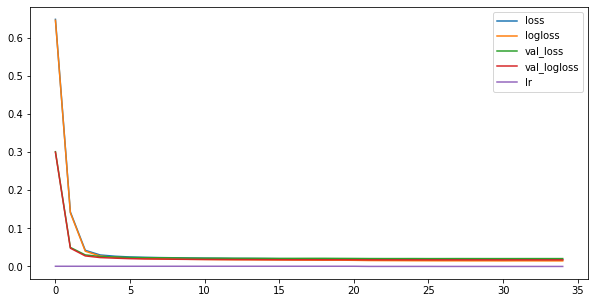

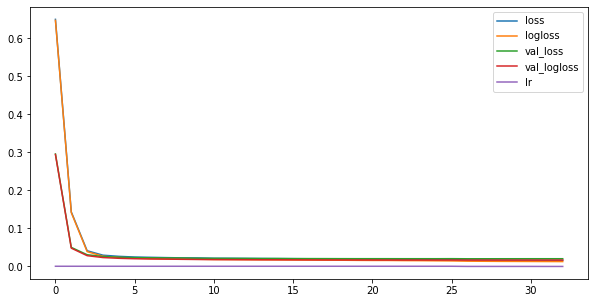

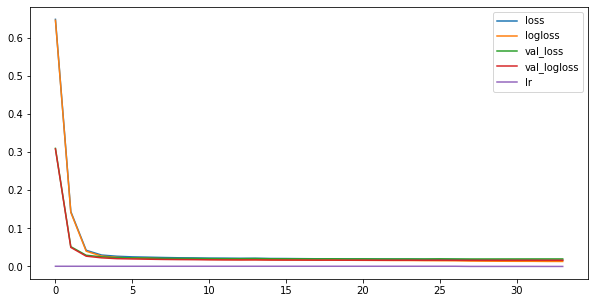

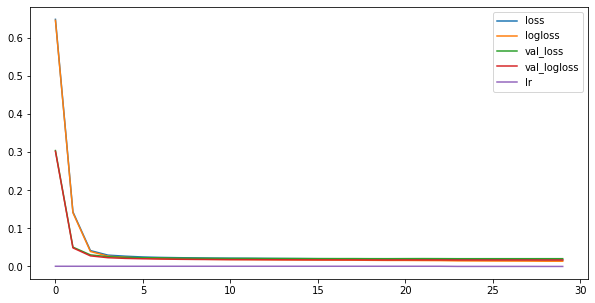

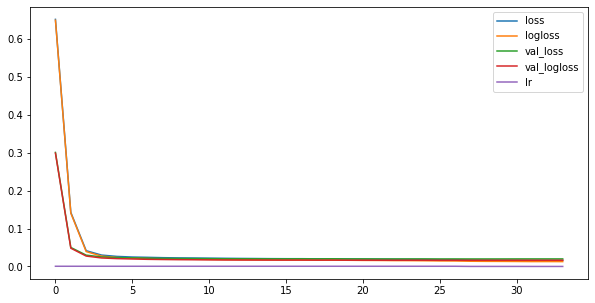

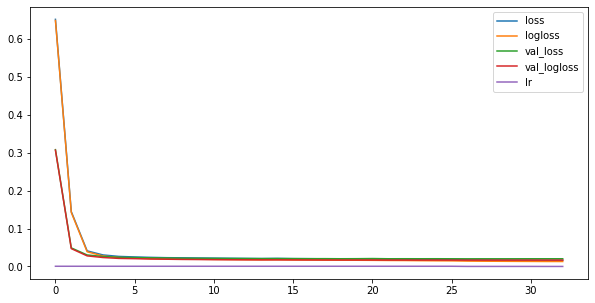

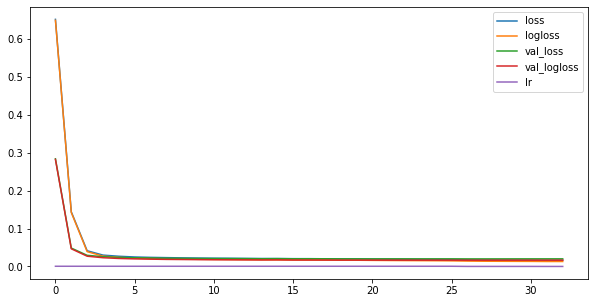

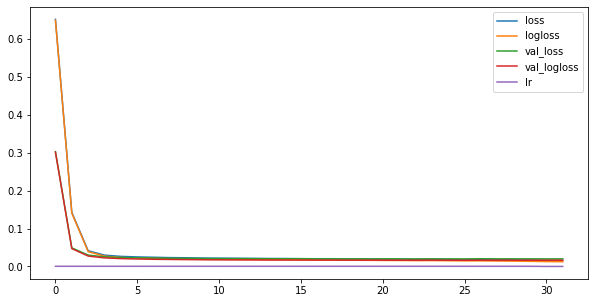

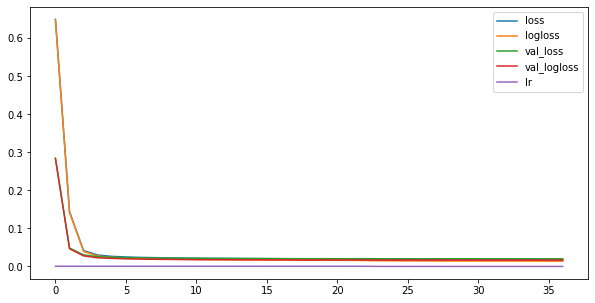

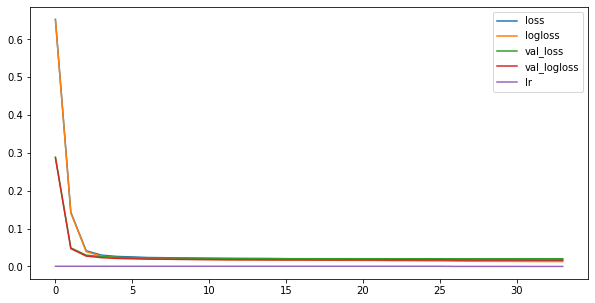

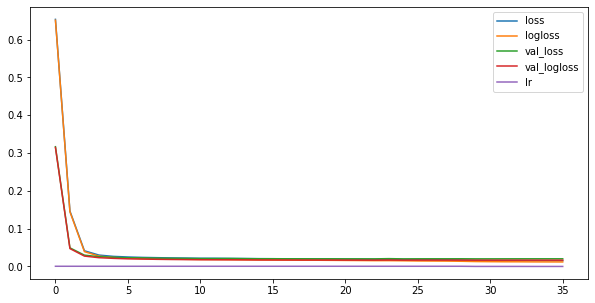

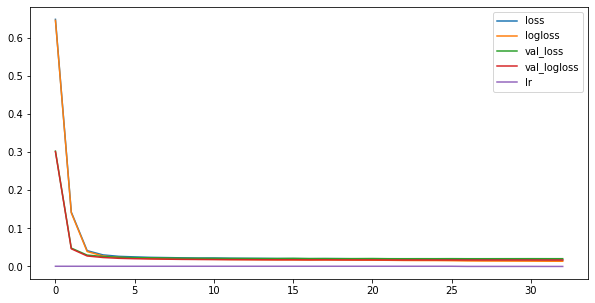

In [22]:
test_pred = training(train_x_final,train_y_final,train_y_ns,k=7,batch_size=128,epochs=50, num_seeds=2, use_nonscored=False)

In [ ]:
test_pred.head(3)